In [1]:
import matplotlib.pyplot as plt
import numpy as np

import torch
from torch import nn
from tqdm.auto import tqdm
from torchvision import transforms
from torchvision.utils import make_grid
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
import torch.distributed as dist
from torch.utils.data.distributed import DistributedSampler
import matplotlib.pyplot as plt
import os
import argparse
torch.manual_seed(0)

/tmp/work/miniconda3/envs/yutung/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## 1. Load image

In [2]:
# Directory path
test_data = "///tmp/dataset-ncku-ml/test" # 'path to your training data'

# List to store the names of subfolders (sample IDs)
sample_ids = []

# Iterate over the items in the directory
for item in os.listdir(test_data):
    item_path = os.path.join(test_data, item)
    if os.path.isdir(item_path):
        sample_ids.append(item)

# Iterate over the items in the directory (limit to first 10 folders)
for idx, item in enumerate((os.listdir(test_data))):
    item_path = os.path.join(test_data, item)
    if os.path.isdir(item_path):
        sample_ids.append(item)

print("Sample IDs:\n", sample_ids[:])

Sample IDs:
 ['2023-10-05_32387297', '2023-10-05_1f452c99', '2023-10-05_865ae126', '2023-10-05_fb63c751', '2023-10-05_922ea8f3', '2023-10-05_aa761dfd', '2023-10-05_5e9037ac', '2023-10-05_bf099af6', '2023-10-05_4234c92f', '2023-10-05_0bbb4a28', '2023-10-05_023d576f', '2023-10-05_645c5c1f', '2023-10-05_a17d89dd', '2023-10-05_f7fa13b2', '2023-10-05_dfe28bb5', '2023-10-05_6bdbcbc0', '2023-10-05_f3434e71', '2023-10-05_5b46df3f', '2023-10-05_e4e4df78', '2023-10-05_b5bbdc53', '2023-10-05_33152a56', '2023-10-05_8b32c36b', '2023-10-05_967db5a2', '2023-10-05_4c0d5692', '2023-10-05_07e566d1', '2023-10-05_a3d0660b', '2023-10-05_9f7308ad', '2023-10-05_2ac3432b', '2023-10-05_9413c875', '2023-10-05_ad743111', '2023-10-05_2e0dfdef', '2023-10-05_62c7affa', '2023-10-05_b1017633', '2023-10-05_e1db2889', '2023-10-05_b54b3af7', '2023-10-05_94554270', '2023-10-05_f61dbb12', '2023-10-05_6f4df1a9', '2023-10-05_47829f35', '2023-10-05_d942e4a3', '2023-10-05_df43e682', '2023-10-05_ebcae8c8', '2023-10-05_d9ef471e

In [3]:
# Choosing one of the samples
sample_id = sample_ids[0]

# Path to the subfolder/sample
sample_path = os.path.join(test_data, sample_id)

# List and print all files in the sample subfolder
files = os.listdir(sample_path)
print("\n Files in the sample subfolder:", files)

# Iterate over the files and load the .npy files.
for file in files:
    if file.startswith("seismicCubes_") and file.endswith(".npy"):
        seismic = np.load(os.path.join(sample_path, file), allow_pickle=True)

print(
    f"\n Seismic array is of the shape: {seismic.shape} and of the data type: {seismic.dtype}"
)


 Files in the sample subfolder: ['seismicCubes_RFC_fullstack_2023.76123161.npy']

 Seismic array is of the shape: (300, 300, 1259) and of the data type: float64


In [4]:
def plot_seismic_and_fault(seismic, line_type, line_num):
    """
    Visualize seismic data with fault overlay and pure fault image.

    Parameters:
        seismic (numpy.ndarray): Seismic volume.
        fault (numpy.ndarray): Fault volume (binary mask).
        line_type (str): Type of line to plot ('inline' or 'xline').
        line_num (int): Line number to visualize.
    """
    if line_type not in ['inline', 'xline']:
        raise ValueError("line_type must be either 'inline' or 'xline'")

    # Determine the slicing direction based on line type
    if line_type == 'inline':
        seismic_slice = seismic[line_num, :, :].T
    elif line_type == 'xline':
        seismic_slice = seismic[:, line_num, :].T

    # Plot the seismic slice with fault overlay
    plt.figure(figsize=(12, 6))

    # Plot seismic with fault overlay
    plt.subplot(1, 2, 1)
    plt.imshow(seismic_slice, cmap='seismic')
    plt.title(f"Seismic Image ({line_type.capitalize()} {line_num})")
    
    plt.tight_layout()
    plt.show()

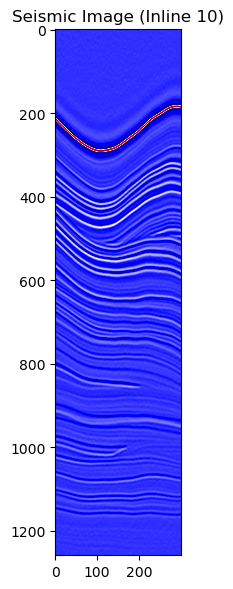

In [5]:
plot_seismic_and_fault(seismic, line_type='inline', line_num=10)

## 2. Dataset

In [6]:
class TestSeismicDataset(Dataset):
    def __init__(self, data_path, slice_dim="depth"):
        self.data_path = data_path
        self.slice_dim = slice_dim

        self.sample_ids = [
            item for item in os.listdir(data_path) if os.path.isdir(os.path.join(data_path, item))
        ]
#         self.sample_ids = all_id[:5]
#         print(self.sample_ids)
        
        # Build global index for all slices
        self.global_indices = []
        for sample_idx, sample_id in enumerate(self.sample_ids):
            sample_dir = os.path.join(data_path, sample_id)
#             print(sample_dir)
            seismic_file = os.path.join(sample_dir, sorted(os.listdir(sample_dir))[0])
#             print(seismic_file)
            seismic_data = np.load(seismic_file)
            
            num_slices = seismic_data.shape[0] if slice_dim == "depth" else None
#             print(num_slices)
#             print("sample_idx = ", sample_idx)
            # Add global indices (sample_idx, slice_idx)
            self.global_indices.extend([(sample_idx, slice_idx) for slice_idx in range(num_slices)])
        
        print(f"Total 2D slices: {len(self.global_indices)}")

    def __len__(self):
        return len(self.global_indices)
    
    def __getitem__(self, idx):
        # Get sample and slice indices
        sample_idx, slice_idx = self.global_indices[idx]
        sample_id = self.sample_ids[sample_idx]
        sample_dir = os.path.join(self.data_path, sample_id)
#         print(sample_dir)

        # Load 3D seismic and fault data
        file_names = sorted(os.listdir(sample_dir))
#         print(file_names[0], file_names[1])
        seismic_file = os.path.join(sample_dir, file_names[0])  # Assuming consistent naming
        seismic_data = np.load(seismic_file)  # (depth, height, width)

        # Extract the specific 2D slice
        if self.slice_dim == "depth":
            image_2d = torch.tensor(seismic_data[slice_idx, :, :], dtype=torch.float32).unsqueeze(0)  # (1, height, width)
        else:
            raise NotImplementedError("Only slicing along depth is currently implemented.")
            
#         print(image_2d)

        return image_2d

## 3. U-Net

In [7]:
class ContractingBlock(nn.Module):
    '''
    ContractingBlock Class
    Performs two convolutions followed by a max pool operation.
    Values:
        input_channels: the number of channels to expect from a given input
    '''
    def __init__(self, input_channels):
        super(ContractingBlock, self).__init__()
        
        # Wou want to double the number of channels in the first convolution
        # and keep the same number of channels in the second.
        
        self.conv1 = nn.Conv2d(input_channels, 2*input_channels, kernel_size=3, padding=(1,1))
        self.conv2 = nn.Conv2d(2*input_channels, 2*input_channels, kernel_size=3, padding=(1,1))
        self.activation = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2)
       

    def forward(self, x):
        '''
        Function for completing a forward pass of ContractingBlock: 
        Given an image tensor, completes a contracting block and returns the transformed tensor.
        Parameters:
            x: image tensor of shape (batch size, channels, height, width)
        '''
        x = self.conv1(x)
        x = self.activation(x)
        x = self.conv2(x)
        x = self.activation(x)
        x = self.maxpool(x)
        return x

In [8]:
class ExpandingBlock(nn.Module):
    '''
    ExpandingBlock Class
    Performs an upsampling, a convolution, a concatenation of its two inputs,
    followed by two more convolutions.
    Values:
        input_channels: the number of channels to expect from a given input
    '''
    def __init__(self, input_channels):
        super(ExpandingBlock, self).__init__()
        
        # "Every step in the expanding path consists of an upsampling of the feature map"
        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)      
        self.conv1 = nn.Conv2d(input_channels, input_channels//2, kernel_size=3, padding=(1,1))
        self.conv2 = nn.Conv2d(input_channels, input_channels//2, kernel_size=3, padding=(1,1))
        self.conv3 = nn.Conv2d(input_channels//2, input_channels//2, kernel_size=3, padding=(1,1))
        
        self.activation = nn.ReLU() # "each followed by a ReLU"
 
    def forward(self, x, skip_con_x):
        '''
        Function for completing a forward pass of ExpandingBlock: 
        Given an image tensor, completes an expanding block and returns the transformed tensor.
        Parameters:
            x: image tensor of shape (batch size, channels, height, width)
            skip_con_x: the image tensor from the contracting path (from the opposing block of x)
                    for the skip connection
                    
        Note: In the original Unet implementation, the output shape is smaller than the input, which 
        requires a skip connection layer size to be matched with current layer. 
        In this application, since our input and output are to be same size, we will note crop the 
        skip connection layer. However, there is a placehold commented, if needed in future. 
        
        '''
        x = self.upsample(x)
        x = self.conv1(x)
        # 确保 x 和 skip_con_x 的形状一致
        diff_h = skip_con_x.shape[2] - x.shape[2]
        diff_w = skip_con_x.shape[3] - x.shape[3]
    
        # 填充 x
        if diff_h > 0 or diff_w > 0:
            x = F.pad(x, [0, diff_w, 0, diff_h])  # [left, right, top, bottom]
        elif diff_h < 0 or diff_w < 0:
            skip_con_x = F.pad(skip_con_x, [0, -diff_w, 0, -diff_h])  # [left, right, top, bottom]
    
        # 拼接
        x = torch.cat([x, skip_con_x], axis=1)
        x = self.conv2(x)
        x = self.activation(x)
        x = self.conv3(x)
        x = self.activation(x)
        return x

In [9]:
class FeatureMapBlock(nn.Module):
    '''
    FeatureMapBlock Class
    The final layer of a UNet - 
    maps each pixel to a pixel with the correct number of output dimensions
    using a 1x1 convolution.
    Values:
        input_channels: the number of channels to expect from a given input
    '''
    def __init__(self, input_channels, output_channels):
        super(FeatureMapBlock, self).__init__()
        
        # "Every step in the expanding path consists of an upsampling of the feature map"
        self.conv = nn.Conv2d(input_channels, output_channels, kernel_size=1)
        

    def forward(self, x):
        '''
        Function for completing a forward pass of FeatureMapBlock: 
        Given an image tensor, returns it mapped to the desired number of channels.
        Parameters:
            x: image tensor of shape (batch size, channels, height, width)
        '''
        x = self.conv(x)
        return x

In [10]:
class UNet(nn.Module):
    '''
    UNet Class
    A series of 4 contracting blocks followed by 4 expanding blocks to 
    transform an input image into the corresponding paired image, with an upfeature
    layer at the start and a downfeature layer at the end
    Values:
        input_channels: the number of channels to expect from a given input
        output_channels: the number of channels to expect for a given output
    '''
    def __init__(self, input_channels, output_channels, hidden_channels=64):
        super(UNet, self).__init__()        
        # "Every step in the expanding path consists of an upsampling of the feature map"
        self.upfeature = FeatureMapBlock(input_channels, hidden_channels)
        self.contract1 = ContractingBlock(hidden_channels)
        self.contract2 = ContractingBlock(hidden_channels * 2)
        self.contract3 = ContractingBlock(hidden_channels * 4)
        self.contract4 = ContractingBlock(hidden_channels * 8)
        self.expand1 = ExpandingBlock(hidden_channels * 16)
        self.expand2 = ExpandingBlock(hidden_channels * 8)
        self.expand3 = ExpandingBlock(hidden_channels * 4)
        self.expand4 = ExpandingBlock(hidden_channels * 2)
        self.downfeature = FeatureMapBlock(hidden_channels, output_channels)
        
    def forward(self, x):
        '''
        Function for completing a forward pass of UNet: 
        Given an image tensor, passes it through U-Net and returns the output.
        Parameters:
            x: image tensor of shape (batch size, channels, height, width)
        '''
        # Keep in mind that the expand function takes two inputs, 
        # both with the same number of channels.                 
        x0 = self.upfeature(x)
        x1 = self.contract1(x0)        
        x2 = self.contract2(x1)        
        x3 = self.contract3(x2)
        x4 = self.contract4(x3)
        
        x5 = self.expand1(x4, x3)
        x6 = self.expand2(x5, x2)
        x7 = self.expand3(x6, x1)
        x8 = self.expand4(x7, x0)
        xn = self.downfeature(x8)          
        return xn

In [11]:
def show_tensor_images(image, pred, num_images=25, size=(1, 28, 28)):
    '''
    Function for visualizing images: Given a tensor of images, number of images, and
    size per image, plots and prints the images in a uniform grid.
    '''
    import matplotlib.pyplot as plt
    # 提取第 0 個樣本的數據
    image_unflat = image[0,...]  # 提取批次中的第 0 張圖像
    pred_unflat = pred[0,...]
    
    print(image_unflat.shape)
    print(pred_unflat.shape)

    # Ensure tensors are detached and moved to CPU
    image_unflat = image_unflat.detach().cpu().squeeze(0).T
    pred_unflat = pred_unflat.detach().cpu().squeeze(0).T

    
    # Ensure tensors have correct range and shape
#     image_unflat = torch.clamp(image_unflat, 0, 1)  # Clamp to [0, 1]
#     fault_unflat = torch.clamp(fault_unflat, 0, 1)
#     pred_unflat = torch.clamp(pred_unflat, 0, 1)


    
    # Plot images
    fig = plt.figure(figsize=(12, 15))
    
#     ax = fig.add_subplot(331)
#     ax.imshow(image_unflat, cmap='seismic', vmin=0, vmax=1)
#     ax.set_title("Seismic Image")
    
#     ax = fig.add_subplot(332)
#     ax.imshow(image_unflat, cmap='seismic', vmin=0, vmax=1)
#     ax.imshow(fault_unflat, cmap='gray', vmin=0, vmax=1, alpha=0.4)
#     ax.set_title("Fault")
    
    ax = fig.add_subplot(333)
    ax.imshow(image_unflat, cmap='seismic', vmin=0, vmax=1)
    ax.imshow(pred_unflat, cmap='gray', vmin=0, vmax=1, alpha=0.4)
    ax.set_title("Predicted Fault")
    
    plt.show()


In [12]:
# 加載模型
def load_model(model_path, input_dim, label_dim, device):
    """
    加載 U-Net 模型。
    Args:
        model_path: 模型權重的文件路徑
        input_dim: 模型輸入維度
        label_dim: 模型輸出維度
        device: 設備 ("cuda" 或 "cpu")
    Returns:
        model: 已加載的模型
    """
    model = torch.nn.DataParallel(UNet(input_dim, label_dim).to(device), device_ids=[0, 1])
#     model = UNet(input_dim, label_dim).to(device)
#     model = torch.nn.SyncBatchNorm.convert_sync_batchnorm(model)
#     model = torch.nn.parallel.DistributedDataParallel(model, device_ids=[args.local_rank], output_device=args.local_rank)
    checkpoint = torch.load(model_path, map_location=device)
    model.load_state_dict(checkpoint["model_state_dict"])
    model.eval()  # 設置為推理模式
    return model


In [13]:
# 將推理結果還原為 3D
def reconstruct_3d_prediction(dataloader, model, device):
    """
    使用模型對切片推理，還原為 3D 張量。
    Args:
        dataloader: 測試資料的 DataLoader
        model: 已訓練的 U-Net 模型
        device: 推理設備
    Returns:
        predictions_3d: 字典，每個 sample_id 對應其 3D 預測結果
    """
    predictions_3d = {}
    current_sample_id = None
    slices = []

    with torch.no_grad():
        for id_x, (image_2d) in tqdm(enumerate(dataloader), total=len(dataloader)):
            # 取得 sample_id 和 slice_idx
            idx = id_x * 10
#             print("idx = ", idx)
            sample_idx, slice_idx = dataloader.dataset.global_indices[idx]
            sample_id = dataloader.dataset.sample_ids[sample_idx]
#             print("sample_idx = ", sample_idx, ", slice_idx = ", slice_idx)  

            if current_sample_id is None:
                current_sample_id = sample_id

            # 如果 sample_id 發生變化，則存儲之前的預測並重置
            if sample_id != current_sample_id:
#                 print(sample_id)
#                 print(np.array(slices).shape)
                predictions_3d[current_sample_id] = np.stack(slices, axis=0)
                slices = []
                current_sample_id = sample_id

            # 推理單張 2D 切片
            image_2d = image_2d.to(device)
#             print(image_2d.shape)
            pred_2d = model(image_2d).squeeze(0)  # (1, 1, H, W) -> (1, H, W)
            pred_2d = torch.sigmoid(pred_2d)
#             print(pred_2d.shape)
            if (slice_idx % 300) == 0:
                show_tensor_images(image_2d, pred_2d)
            
            pred_2d = pred_2d.squeeze(0).cpu().numpy()  # 激活並還原到 NumPy 格式
            pred_2d_binary = (pred_2d > 0.5).astype(np.uint16)  # 二值化處理 (threshold = 0.5)

#             print(pred_2d.shape)
#             print(pred_2d_binary.shape)
            slices.append(pred_2d_binary)
#             print(len(slices))

        # 處理最後一個樣本
        if current_sample_id is not None:
#             print(np.array(slices).shape)
            predictions_3d[current_sample_id] = np.stack(slices, axis=0)

    return predictions_3d

In [14]:
# 提取 Fault Coordinates 並保存為 npz 文件
def save_predictions_as_npz(predictions_3d, save_path):
    """
    將 3D 預測結果轉換為 Fault Coordinates，並保存為 .npz 文件。
    Args:
        predictions_3d: 字典，每個 sample_id 對應其 3D 預測結果
        save_path: 保存的文件路徑
    """
    fault_data = {}
    for sample_id, prediction_3d in predictions_3d.items():
        # 提取值為 1 的坐標
        fault_coords = np.argwhere(prediction_3d == 1)
        fault_data[sample_id] = fault_coords

    # 保存為 .npz 文件
    np.savez_compressed(save_path, **fault_data)
    print(f"Inference results saved to {save_path}")

In [15]:
# 主推理函數
def infer_and_save_results(test_data_path, model_path, save_path, input_dim=1, label_dim=1, batch_size=1, device="cuda"):
    """
    主函數，執行推理並保存結果。
    Args:
        test_data_path: 測試資料的路徑
        model_path: U-Net 模型的路徑
        save_path: 保存的 .npz 文件路徑
        input_dim: 模型輸入維度
        label_dim: 模型輸出維度
        batch_size: 推理批次大小
        device: 設備 ("cuda" 或 "cpu")
    """
#     # 設置 local_rank argparse 參數
#     parser = argparse.ArgumentParser()
#     parser.add_argument("--local_rank", default=0, type=int)
#     args = parser.parse_args()
    
#     # 初始化DDP
#     dist.init_process_group(backend='nccl')
#     dist.barrier()
#     world_size = dist.get_world_size()
    
    
    # 加載測試資料
    dataset = TestSeismicDataset(data_path=test_data, slice_dim="depth")
#     test_sampler = DistributedSampler(dataset)
#     dataloader = DataLoader(dataset, sampler=test_sampler, batch_size=10, pin_memory=False, prefetch_factor=2)
    dataloader = DataLoader(dataset, batch_size=10, shuffle=False)

    # 查看单个 batch
    for batch_idx, (images) in enumerate(dataloader):
        print(f"Batch {batch_idx + 1}:")
        print(f"Images shape: {images.shape}")  # (batch_size, 1, height, width)
#         print(images)
        break
    
    # 加載模型
#     device = torch.device("cuda", args.local_rank)
    device = torch.device("cuda:0" if (torch.cuda.is_available()) else "cpu")
    model = load_model(model_path, input_dim, label_dim, device)

    # 進行推理
    predictions_3d = reconstruct_3d_prediction(dataloader, model, device)
    print(predictions_3d)

    # 保存為 npz 文件
    save_predictions_as_npz(predictions_3d, save_path)

Total 2D slices: 15000
Batch 1:
Images shape: torch.Size([10, 1, 300, 1259])


/tmp/ipykernel_3909/2008019862.py:17: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(model_path, map_location=device)
  0%|          | 0/1500 [00:00<?

torch.Size([1, 300, 1259])
torch.Size([1, 300, 1259])


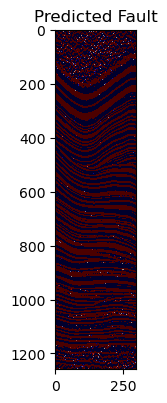

  2%|▏         | 30/1500 [02:04<1:41:17,  4.13s/it]

torch.Size([1, 300, 1259])
torch.Size([1, 300, 1259])


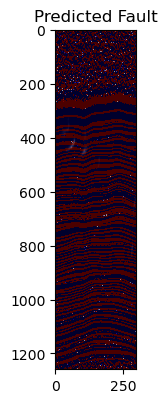

  4%|▍         | 60/1500 [04:07<1:38:35,  4.11s/it]

torch.Size([1, 300, 1259])
torch.Size([1, 300, 1259])


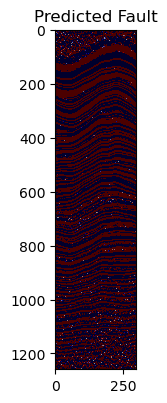

  6%|▌         | 90/1500 [06:11<1:36:16,  4.10s/it]

torch.Size([1, 300, 1259])
torch.Size([1, 300, 1259])


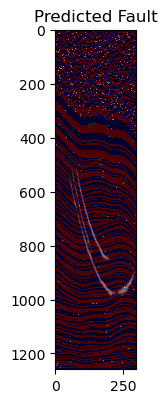

  8%|▊         | 120/1500 [08:16<1:36:22,  4.19s/it]

torch.Size([1, 300, 1259])
torch.Size([1, 300, 1259])


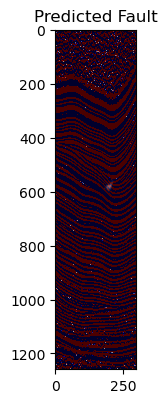

 10%|█         | 150/1500 [10:21<1:34:07,  4.18s/it]

torch.Size([1, 300, 1259])
torch.Size([1, 300, 1259])


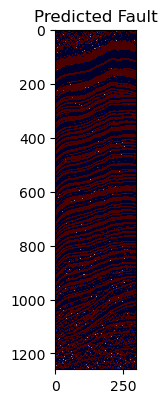

 12%|█▏        | 180/1500 [12:27<1:32:22,  4.20s/it]

torch.Size([1, 300, 1259])
torch.Size([1, 300, 1259])


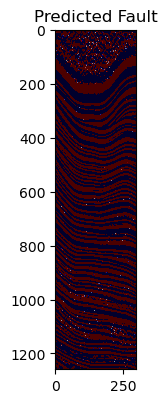

 14%|█▍        | 210/1500 [14:32<1:30:06,  4.19s/it]

torch.Size([1, 300, 1259])
torch.Size([1, 300, 1259])


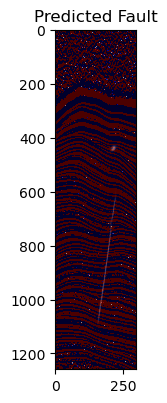

 16%|█▌        | 240/1500 [16:35<1:28:06,  4.20s/it]

torch.Size([1, 300, 1259])
torch.Size([1, 300, 1259])


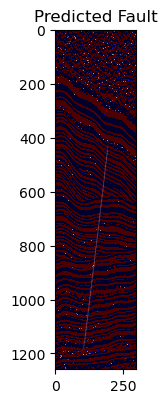

 18%|█▊        | 270/1500 [18:40<1:23:04,  4.05s/it]

torch.Size([1, 300, 1259])
torch.Size([1, 300, 1259])


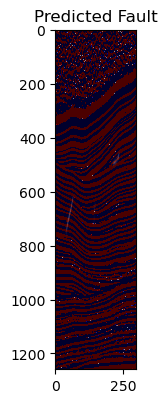

 20%|██        | 300/1500 [20:35<1:16:57,  3.85s/it]

torch.Size([1, 300, 1259])
torch.Size([1, 300, 1259])


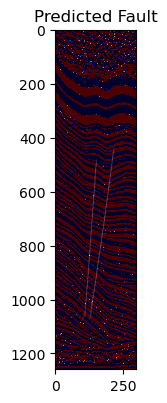

 22%|██▏       | 330/1500 [22:38<1:18:09,  4.01s/it]

torch.Size([1, 300, 1259])
torch.Size([1, 300, 1259])


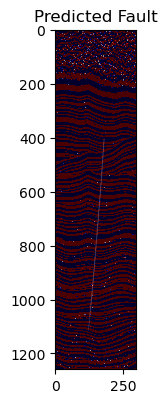

 24%|██▍       | 360/1500 [24:42<1:19:06,  4.16s/it]

torch.Size([1, 300, 1259])
torch.Size([1, 300, 1259])


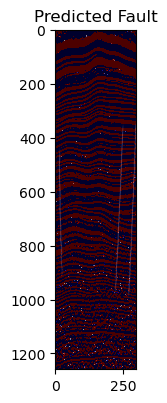

 26%|██▌       | 390/1500 [26:47<1:15:55,  4.10s/it]

torch.Size([1, 300, 1259])
torch.Size([1, 300, 1259])


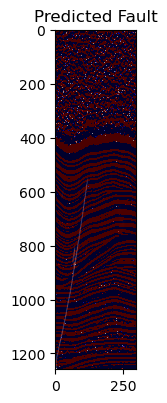

 28%|██▊       | 420/1500 [28:51<1:15:20,  4.19s/it]

torch.Size([1, 300, 1259])
torch.Size([1, 300, 1259])


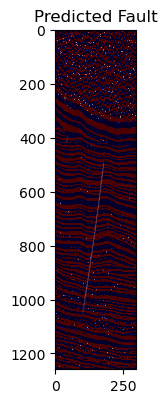

 30%|███       | 450/1500 [30:57<1:12:25,  4.14s/it]

torch.Size([1, 300, 1259])
torch.Size([1, 300, 1259])


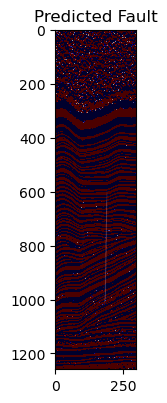

 32%|███▏      | 480/1500 [32:59<1:08:35,  4.04s/it]

torch.Size([1, 300, 1259])
torch.Size([1, 300, 1259])


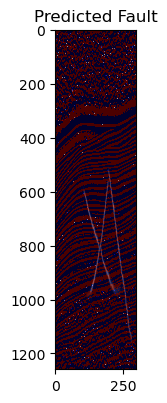

 34%|███▍      | 510/1500 [35:04<1:08:40,  4.16s/it]

torch.Size([1, 300, 1259])
torch.Size([1, 300, 1259])


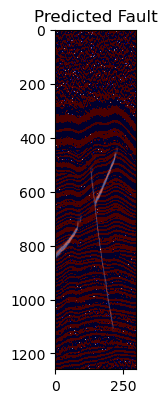

 36%|███▌      | 540/1500 [37:10<1:07:07,  4.20s/it]

torch.Size([1, 300, 1259])
torch.Size([1, 300, 1259])


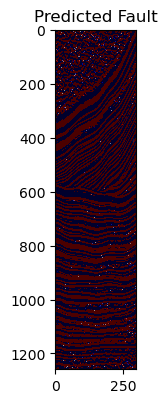

 38%|███▊      | 570/1500 [39:15<1:04:28,  4.16s/it]

torch.Size([1, 300, 1259])
torch.Size([1, 300, 1259])


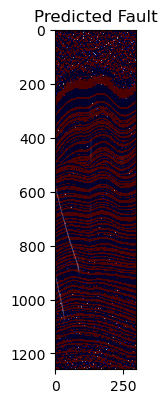

 40%|████      | 600/1500 [41:17<1:00:59,  4.07s/it]

torch.Size([1, 300, 1259])
torch.Size([1, 300, 1259])


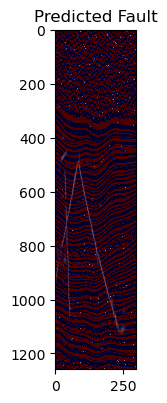

 42%|████▏     | 630/1500 [43:19<55:16,  3.81s/it]  

torch.Size([1, 300, 1259])
torch.Size([1, 300, 1259])


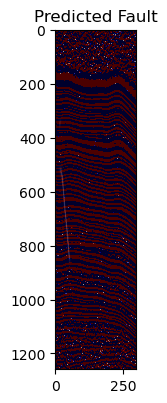

 44%|████▍     | 660/1500 [45:23<57:34,  4.11s/it]

torch.Size([1, 300, 1259])
torch.Size([1, 300, 1259])


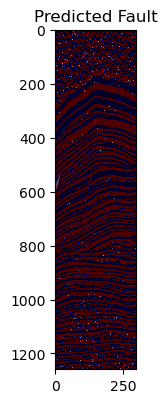

 46%|████▌     | 690/1500 [47:26<56:31,  4.19s/it]

torch.Size([1, 300, 1259])
torch.Size([1, 300, 1259])


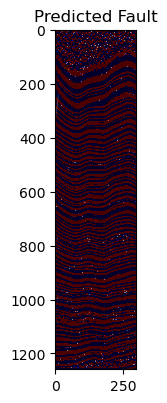

 48%|████▊     | 720/1500 [49:12<45:50,  3.53s/it]

torch.Size([1, 300, 1259])
torch.Size([1, 300, 1259])


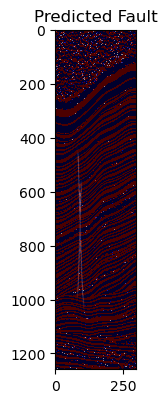

 50%|█████     | 750/1500 [51:14<50:00,  4.00s/it]

torch.Size([1, 300, 1259])
torch.Size([1, 300, 1259])


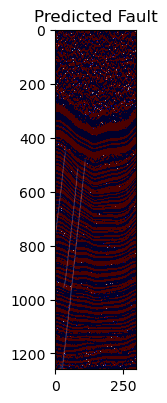

 52%|█████▏    | 780/1500 [53:19<50:19,  4.19s/it]

torch.Size([1, 300, 1259])
torch.Size([1, 300, 1259])


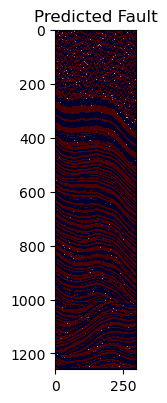

 54%|█████▍    | 810/1500 [55:25<47:52,  4.16s/it]

torch.Size([1, 300, 1259])
torch.Size([1, 300, 1259])


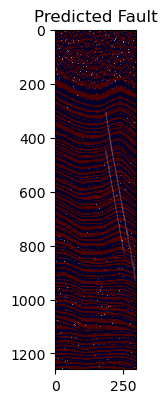

 56%|█████▌    | 840/1500 [57:30<46:01,  4.18s/it]

torch.Size([1, 300, 1259])
torch.Size([1, 300, 1259])


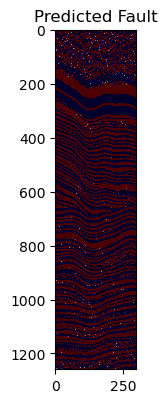

 58%|█████▊    | 870/1500 [59:36<43:04,  4.10s/it]

torch.Size([1, 300, 1259])
torch.Size([1, 300, 1259])


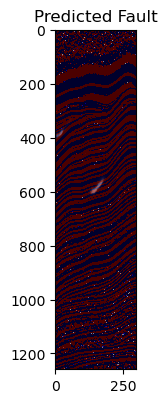

 60%|██████    | 900/1500 [1:01:42<41:42,  4.17s/it]

torch.Size([1, 300, 1259])
torch.Size([1, 300, 1259])


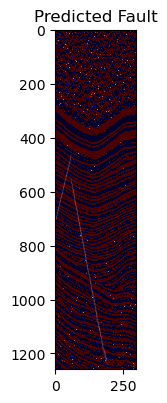

 62%|██████▏   | 930/1500 [1:03:49<39:39,  4.17s/it]

torch.Size([1, 300, 1259])
torch.Size([1, 300, 1259])


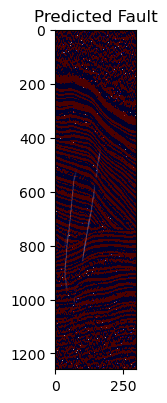

 64%|██████▍   | 960/1500 [1:05:40<32:48,  3.65s/it]

torch.Size([1, 300, 1259])
torch.Size([1, 300, 1259])


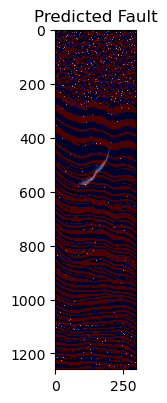

 66%|██████▌   | 990/1500 [1:07:47<35:04,  4.13s/it]

torch.Size([1, 300, 1259])
torch.Size([1, 300, 1259])


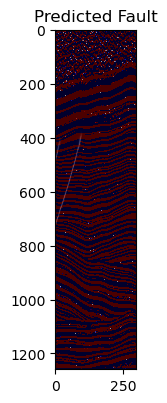

 68%|██████▊   | 1020/1500 [1:09:42<30:23,  3.80s/it]

torch.Size([1, 300, 1259])
torch.Size([1, 300, 1259])


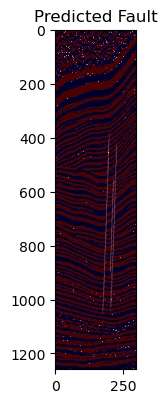

 70%|███████   | 1050/1500 [1:11:45<30:51,  4.11s/it]

torch.Size([1, 300, 1259])
torch.Size([1, 300, 1259])


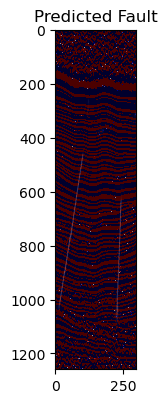

 72%|███████▏  | 1080/1500 [1:13:51<29:22,  4.20s/it]

torch.Size([1, 300, 1259])
torch.Size([1, 300, 1259])


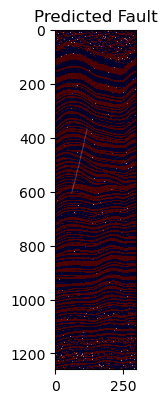

 74%|███████▍  | 1110/1500 [1:15:57<27:18,  4.20s/it]

torch.Size([1, 300, 1259])
torch.Size([1, 300, 1259])


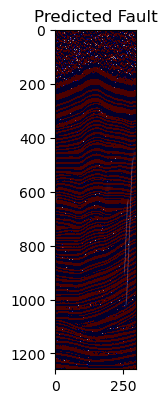

 76%|███████▌  | 1140/1500 [1:17:59<24:52,  4.15s/it]

torch.Size([1, 300, 1259])
torch.Size([1, 300, 1259])


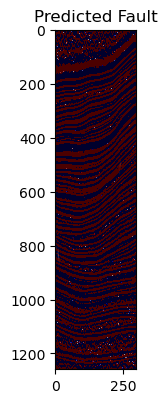

 78%|███████▊  | 1170/1500 [1:20:05<22:45,  4.14s/it]

torch.Size([1, 300, 1259])
torch.Size([1, 300, 1259])


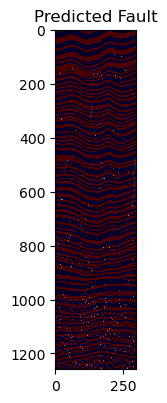

 80%|████████  | 1200/1500 [1:22:10<20:50,  4.17s/it]

torch.Size([1, 300, 1259])
torch.Size([1, 300, 1259])


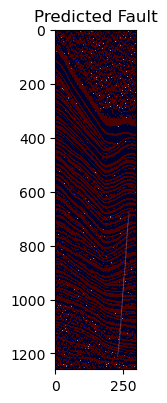

 82%|████████▏ | 1230/1500 [1:24:15<18:47,  4.18s/it]

torch.Size([1, 300, 1259])
torch.Size([1, 300, 1259])


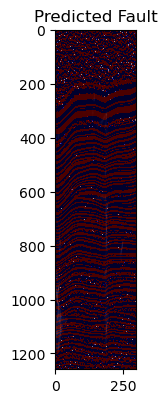

 84%|████████▍ | 1260/1500 [1:26:21<16:41,  4.17s/it]

torch.Size([1, 300, 1259])
torch.Size([1, 300, 1259])


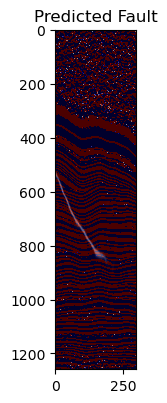

 86%|████████▌ | 1290/1500 [1:28:16<13:17,  3.80s/it]

torch.Size([1, 300, 1259])
torch.Size([1, 300, 1259])


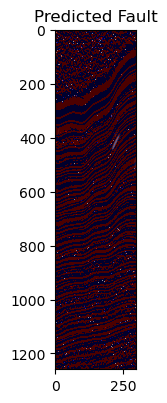

 88%|████████▊ | 1320/1500 [1:30:20<12:33,  4.19s/it]

torch.Size([1, 300, 1259])
torch.Size([1, 300, 1259])


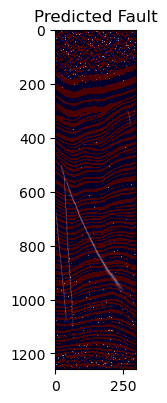

 90%|█████████ | 1350/1500 [1:32:23<10:16,  4.11s/it]

torch.Size([1, 300, 1259])
torch.Size([1, 300, 1259])


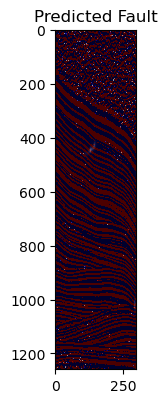

 92%|█████████▏| 1380/1500 [1:34:17<07:29,  3.74s/it]

torch.Size([1, 300, 1259])
torch.Size([1, 300, 1259])


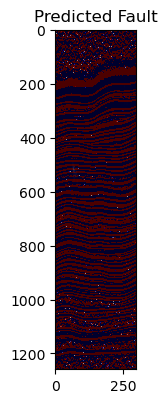

 94%|█████████▍| 1410/1500 [1:36:21<06:15,  4.17s/it]

torch.Size([1, 300, 1259])
torch.Size([1, 300, 1259])


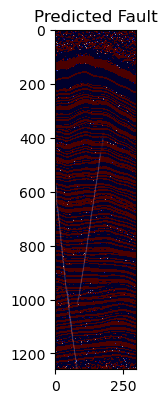

 96%|█████████▌| 1440/1500 [1:38:24<03:59,  3.99s/it]

torch.Size([1, 300, 1259])
torch.Size([1, 300, 1259])


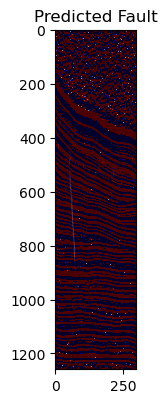

 98%|█████████▊| 1470/1500 [1:40:27<02:04,  4.15s/it]

torch.Size([1, 300, 1259])
torch.Size([1, 300, 1259])


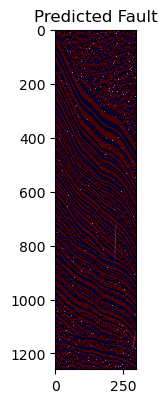

100%|██████████| 1500/1500 [1:42:32<00:00,  4.10s/it]


{'2023-10-05_32387297': array([[[[[0, 0, 0, ..., 0, 0, 0],
          [0, 0, 0, ..., 0, 0, 0],
          [0, 0, 0, ..., 0, 0, 0],
          ...,
          [0, 0, 0, ..., 0, 0, 0],
          [0, 0, 0, ..., 0, 0, 0],
          [0, 0, 0, ..., 0, 0, 0]]],


        [[[0, 0, 0, ..., 0, 0, 0],
          [0, 0, 0, ..., 0, 0, 0],
          [0, 0, 0, ..., 0, 0, 0],
          ...,
          [0, 0, 0, ..., 0, 0, 0],
          [0, 0, 0, ..., 0, 0, 0],
          [0, 0, 0, ..., 0, 0, 0]]],


        [[[0, 0, 0, ..., 0, 0, 0],
          [0, 0, 0, ..., 0, 0, 0],
          [0, 0, 0, ..., 0, 0, 0],
          ...,
          [0, 0, 0, ..., 0, 0, 0],
          [0, 0, 0, ..., 0, 0, 0],
          [0, 0, 0, ..., 0, 0, 0]]],


        ...,


        [[[0, 0, 0, ..., 0, 0, 0],
          [0, 0, 0, ..., 0, 0, 0],
          [0, 0, 0, ..., 0, 0, 0],
          ...,
          [0, 0, 0, ..., 0, 0, 0],
          [0, 0, 0, ..., 0, 0, 0],
          [0, 0, 0, ..., 0, 0, 0]]],


        [[[0, 0, 0, ..., 0, 0, 0],
          

In [16]:
# 設定路徑與參數
test_data_path = "///tmp/dataset-ncku-ml/test"  # 測試資料的路徑
model_path = "///tmp/work/yutung/model_saved/unet_epoch_3.pth"  # 模型文件路徑
save_path = "///tmp/work/yutung/test/fault_predictions.npz"  # 保存的 .npz 文件路徑

# 運行推理並保存結果
infer_and_save_results(test_data_path, model_path, save_path, input_dim=1, label_dim=1, batch_size=1, device="cuda" if torch.cuda.is_available() else "cpu")

In [17]:
infer_data = np.load("///tmp/work/yutung/test/fault_predictions.npz", mmap_mode='r')
for k in infer_data.files:
    print(k)
print(infer_data)
# print(infer_data['2023-10-05_84d63823'])

2023-10-05_32387297
2023-10-05_1f452c99
2023-10-05_865ae126
2023-10-05_fb63c751
2023-10-05_922ea8f3
2023-10-05_aa761dfd
2023-10-05_5e9037ac
2023-10-05_bf099af6
2023-10-05_4234c92f
2023-10-05_0bbb4a28
2023-10-05_023d576f
2023-10-05_645c5c1f
2023-10-05_a17d89dd
2023-10-05_f7fa13b2
2023-10-05_dfe28bb5
2023-10-05_6bdbcbc0
2023-10-05_f3434e71
2023-10-05_5b46df3f
2023-10-05_e4e4df78
2023-10-05_b5bbdc53
2023-10-05_33152a56
2023-10-05_8b32c36b
2023-10-05_967db5a2
2023-10-05_4c0d5692
2023-10-05_07e566d1
2023-10-05_a3d0660b
2023-10-05_9f7308ad
2023-10-05_2ac3432b
2023-10-05_9413c875
2023-10-05_ad743111
2023-10-05_2e0dfdef
2023-10-05_62c7affa
2023-10-05_b1017633
2023-10-05_e1db2889
2023-10-05_b54b3af7
2023-10-05_94554270
2023-10-05_f61dbb12
2023-10-05_6f4df1a9
2023-10-05_47829f35
2023-10-05_d942e4a3
2023-10-05_df43e682
2023-10-05_ebcae8c8
2023-10-05_d9ef471e
2023-10-05_84d63823
2023-10-05_23249287
2023-10-05_01b243eb
2023-10-05_e872bbc1
2023-10-05_8dcd49d9
2023-10-05_f954e61e
2023-10-05_964a83ae


In [18]:
# import numpy as np

# # 載入原始 npz 文件
# input_path = "///tmp/work/yutung/test/fault_predictions.npz"
# output_path = "///tmp/work/yutung/test/fault_predictions_filtered.npz"

# data = np.load(input_path)

# # 新的字典用於保存過濾後的數據
# filtered_data = {}

# for sample_id, coords in data.items():
#     # coords shape: (num_coords, 5) -> columns: [depth, channel, z, x, y]
#     print(coords.shape)
    
#     # 過濾只保留 [depth, x, y]
#     filtered_coords = coords[:, [0, 3, 4]]
    
#     # 保存過濾後的坐標
#     filtered_data[sample_id] = filtered_coords

# # 保存新的 npz 文件
# np.savez_compressed(output_path, **filtered_data)

# print(f"Filtered npz file saved to {output_path}")

import numpy as np

# 載入原始 npz 文件
input_path = "///tmp/work/yutung/test/fault_predictions.npz"
output_path = "///tmp/work/yutung/test/fault_predictions_corrected.npz"

data = np.load(input_path)

# 新的字典用於保存修正後的數據
corrected_data = {}

for sample_id, coords in data.items():
    # coords shape: (num_coords, 5) -> columns: [batch num, batch, channel, x, y]
    print(f"Original shape for {sample_id}: {coords.shape}")
#     print(coords)
    
    # 計算新的 depth 值：batch num * 10 + batch
    new_depth = coords[:, 0] * 10 + coords[:, 1]
    
    # 合併新的 depth 和 [x, y] 的值
    corrected_coords = np.stack((new_depth, coords[:, 3], coords[:, 4]), axis=1)
    
    # 保存修正後的數據
    corrected_data[sample_id] = corrected_coords

# 保存新的 npz 文件
np.savez_compressed(output_path, **corrected_data)

print(f"Corrected npz file saved to {output_path}")

Original shape for 2023-10-05_32387297: (338288, 5)
Original shape for 2023-10-05_1f452c99: (984971, 5)
Original shape for 2023-10-05_865ae126: (314892, 5)
Original shape for 2023-10-05_fb63c751: (570108, 5)
Original shape for 2023-10-05_922ea8f3: (43562, 5)
Original shape for 2023-10-05_aa761dfd: (106530, 5)
Original shape for 2023-10-05_5e9037ac: (41501, 5)
Original shape for 2023-10-05_bf099af6: (169973, 5)
Original shape for 2023-10-05_4234c92f: (688396, 5)
Original shape for 2023-10-05_0bbb4a28: (676618, 5)
Original shape for 2023-10-05_023d576f: (697565, 5)
Original shape for 2023-10-05_645c5c1f: (277593, 5)
Original shape for 2023-10-05_a17d89dd: (1121185, 5)
Original shape for 2023-10-05_f7fa13b2: (409307, 5)
Original shape for 2023-10-05_dfe28bb5: (296331, 5)
Original shape for 2023-10-05_6bdbcbc0: (519623, 5)
Original shape for 2023-10-05_f3434e71: (773991, 5)
Original shape for 2023-10-05_5b46df3f: (449985, 5)
Original shape for 2023-10-05_e4e4df78: (553673, 5)
Original shap

In [19]:
infer_data = np.load("///tmp/work/yutung/test/fault_predictions_corrected.npz")
for x in infer_data.files:
    print(x)
print(infer_data['2023-10-05_32387297'])

2023-10-05_32387297
2023-10-05_1f452c99
2023-10-05_865ae126
2023-10-05_fb63c751
2023-10-05_922ea8f3
2023-10-05_aa761dfd
2023-10-05_5e9037ac
2023-10-05_bf099af6
2023-10-05_4234c92f
2023-10-05_0bbb4a28
2023-10-05_023d576f
2023-10-05_645c5c1f
2023-10-05_a17d89dd
2023-10-05_f7fa13b2
2023-10-05_dfe28bb5
2023-10-05_6bdbcbc0
2023-10-05_f3434e71
2023-10-05_5b46df3f
2023-10-05_e4e4df78
2023-10-05_b5bbdc53
2023-10-05_33152a56
2023-10-05_8b32c36b
2023-10-05_967db5a2
2023-10-05_4c0d5692
2023-10-05_07e566d1
2023-10-05_a3d0660b
2023-10-05_9f7308ad
2023-10-05_2ac3432b
2023-10-05_9413c875
2023-10-05_ad743111
2023-10-05_2e0dfdef
2023-10-05_62c7affa
2023-10-05_b1017633
2023-10-05_e1db2889
2023-10-05_b54b3af7
2023-10-05_94554270
2023-10-05_f61dbb12
2023-10-05_6f4df1a9
2023-10-05_47829f35
2023-10-05_d942e4a3
2023-10-05_df43e682
2023-10-05_ebcae8c8
2023-10-05_d9ef471e
2023-10-05_84d63823
2023-10-05_23249287
2023-10-05_01b243eb
2023-10-05_e872bbc1
2023-10-05_8dcd49d9
2023-10-05_f954e61e
2023-10-05_964a83ae


In [ ]:
import numpy as np

# 加载目标 npz 文件
input_file_path = "///tf/fault_predictions_corrected.npz"
output_file_path = "///tf/fault_predictions_uint16.npz"

# 加载数据
data = np.load(input_file_path, allow_pickle=True)
print(type(data['2023-10-05_aa761dfd']))
print(data['2023-10-05_aa761dfd'].dtype)

# 转换每个样本的 dtype 为 numpy.uint16
converted_data = {key: value.astype(np.uint16) for key, value in data.items()}

# 保存为新的 npz 文件
np.savez_compressed(output_file_path, **converted_data)
print(f"Converted file saved at: {output_file_path}")

data = np.load(output_file_path, allow_pickle=True)
print(data['2023-10-05_aa761dfd'])